In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import cv2

#specify
CAR_PATH = ''
LP_PATH = ''

#read car in grayscale, color and threshold and LP in grayscale
car = cv2.imread(CAR_PATH,0)
lp = cv2.imread(LP_PATH,0)


# 16 different template sizes - greater chance of success


def lp_finder_16(car):
    
    '''Function which returns list of  16 grayscale licence plate images, cropped from image of a car.
    Uses template matching, with 16 different template LP shapes.
    
    Params:
    car - grayscale image of a car
    lp - grayscale image of template licence plate'''
    
    #reshape car image to 600x400 - not used here, original images give better results if not huge
    #reshaping changes length and height ratios, which decreases algorithm efficiency 
    #since LP template shapes are hardcoded
    car_r = cv2.resize(car, (600,400))
    #thresholding car image
    car_th = cv2.threshold(car_r, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    car_canny = cv2.Canny(car_th, 200,400)
    
    
    #for 16 different LP sizes
    #getting resizing values for test licence plate
    shape1 = np.arange(150,230,5)
    shape2 = np.arange(56,84,1.5)
    #shape2 contains floats, converting to ints
    shape3 = []
    for i in shape2:
        shape3.append(int(i))
    #creating tuples (shape1,shape3) in single list
    sizes = zip(shape1,shape3)
    sizes = list(sizes)
    
    #creating lp mask
    lp = np.zeros((70,170), dtype=np.uint8)
    lp = cv2.rectangle(lp, (3,3), (167,67), 255, -1)
    # list of thresholded plates in all sizes
    plates = []
    for i in range(0, len(sizes)):
        plates.append(cv2.resize(lp, sizes[i]))

    #matching car with each LP size
    matches = []
    #list of matches for each size
    for i in plates:
        matches.append(cv2.matchTemplate(car_canny, i, cv2.TM_CCOEFF))
    
    #appends location of matched squares to list, inverted to (x,y), for thresh
    #minMaxLoc finds maximum for each match
    locs = []
    for i in range(0, len(matches)):
        locs.append(tuple(cv2.minMaxLoc(matches[i])[3]))
    
    
    #creates masks for images, where only LP remains
    masks = []
    for i in range(0,len(plates)):
        black = np.zeros(car.shape, dtype=np.uint8)
        black = cv2.rectangle(black, locs[i], (locs[i][0]+plates[i].shape[1], locs[i][1]+plates[i].shape[0]), 255, -1)
        masks.append(black)
    
    #keeping only LP - cropped list contains all cropped images of LPs
    cropped = []
    for i in range(0,len(plates)):
        masked = cv2.bitwise_and(car, car, mask=masks[i])
        x,y = np.where(masked!=0)
        topx = x.min()
        bottomx = x.max()
        topy=y.min()
        bottomy=y.max()
        crop = masked[topx:bottomx,topy:bottomy]
        cropped.append(crop)
        
    return(cropped)   

In [532]:
import numpy as np
import cv2

def lp_finder_3(car):
    
    '''Function which returns list of 3 licence plate images, cropped from image of a car.
    Uses template matching, with 3 different template shapes of white rectange with black edges.
    
    Params:
    car - image of a car'''
    

    #changing car image to grayscale
    car = cv2.cvtColor(car, cv2.COLOR_BGR2GRAY)
    #resizing to 600x400
    car_r = cv2.resize(car, (400,400))
    #thresholding using Otsu binarization
    car_th = cv2.threshold(car_r, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    #getting canny
    car_canny = cv2.Canny(car_th, 200,400)
    
    #3 different lp sizes
    sizes = [(120,25),(130,30),(140,35)]
    
    #creating lp kernel for template matching - white rectangle with black edges
    lp = np.zeros((56,150), dtype=np.uint8)
    lp = cv2.rectangle(lp, (3,3), (147,53), 255, -1)
    # list of thresholded plates in all sizes
    plates = []
    for i in range(len(sizes)):
        plates.append(cv2.resize(lp, sizes[i]))

    #matching car with each LP size
    matches = []
    #list of matches for each size
    for i in plates:
        matches.append(cv2.matchTemplate(car_canny, i, cv2.TM_CCOEFF))
    
    #appends location of matched squares to list, inverted to (x,y), for thresh
    #minMaxLoc finds maximum for each match
    locs = []
    for i in range(len(matches)):
        locs.append(tuple(cv2.minMaxLoc(matches[i])[3]))
        
    
    #creates masks for images, where only LP remains
    masks = []
    for i in range(len(plates)):
        black = np.zeros(car_r.shape, dtype=np.uint8)
        black = cv2.rectangle(black, locs[i], (locs[i][0]+plates[i].shape[1], locs[i][1]+plates[i].shape[0]), 255, -1)
        masks.append(black)
        
    #returning masks to original input image size
    #this way, original size of LP is returned
    masks_r = []
    for i in masks:
        masks_r.append(cv2.resize(i, tuple([car.shape[1], car.shape[0]])))
    
    #keeping only LP - cropped list contains all cropped images of LPs
    cropped = []
    for i in range(len(plates)):
        masked = cv2.bitwise_and(car, car, mask=masks_r[i])
        x,y = np.where(masked!=0)
        topx = x.min()
        bottomx = x.max()
        topy=y.min()
        bottomy=y.max()
        crop = masked[topx:bottomx,topy:bottomy]
        cropped.append(crop)
        
    return(cropped)

In [2712]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract as tess
import string

In [2740]:
#reading image for testing
car = cv2.imread('auti_ista_rez/6.jpg')
regs = lp_finder_3(car)

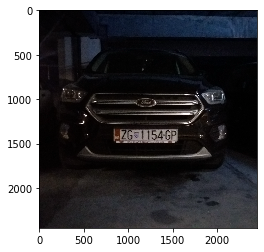

In [2741]:
plt.imshow(car)

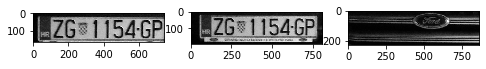

In [2742]:
plt.figure(figsize=(8,4))
for i in range(len(regs)):
    plt.subplot(3,3,i+1)
    plt.imshow(regs[i], cmap='gray')

In [2743]:
#making thresholded plates for tesseract
regs_th = []
for i in regs:
    regs_th.append(cv2.threshold(i, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1])
# adding morph closing before median filtering (denoiser) for each image
for i in range(len(regs_th2)):
    regs_th.append(cv2.morphologyEx(cv2.medianBlur(regs_th[i], 5), op=cv2.MORPH_OPEN, kernel=(7,7)))
# adding original images
for i in regs:
    regs_th.append(i)

In [2744]:
#allowed characters in plates
#letters
char = list(string.ascii_uppercase)
#numbers
for i in range (0,10):
    char.append(str(i))
 #removing non croatian letters
char.remove('Q')
char.remove('W')
char.remove('X')
char.remove('Y')
print(char)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [2745]:
#making list of all things tesseract reads
all_regs = []
#reading each image
for i in range(len(regs_th)):
    all_regs.append(tess.image_to_string(regs_th[i], config='--psm 8'))
    #uppercasing
    for j in range(len(all_regs)):
        all_regs[j] = all_regs[j].upper()
#getting rid of all non sucessful reads (i.e. if empty string is returned)
all_regs_clean = []
for i in all_regs:
    if i != '':
        all_regs_clean.append(i)

In [2746]:
all_regs_clean

['187G71154-GP',
 'BA ZG"1154-GP)',
 'A',
 '187G71154-GP',
 'BA Z2G"1154-GP}',
 'A',
 '187G21154-GP',
 'BA ZG"1154-GP}',
 'EE']

In [2747]:
#basic cleaning
for i in range(len(all_regs_clean)):
    for j in all_regs_clean[i]:
        if j == '|':
            all_regs_clean[i] = all_regs_clean[i].replace(j,'I')
        elif j == '(':
            all_regs_clean[i] = all_regs_clean[i].replace(j,'C')

#removing all not allowed characters (those not in char)
for i in range(len(all_regs_clean)):
    for j in all_regs_clean[i]:
        if j not in char:
            all_regs_clean[i] = all_regs_clean[i].replace(j,'')
for i in all_regs_clean:
    if len(i) < 3:
        all_regs_clean.remove(i)
all_regs_clean

['187G71154GP',
 'BAZG1154GP',
 '187G71154GP',
 'BAZ2G1154GP',
 '187G21154GP',
 'BAZG1154GP']

# City

In [2748]:
#city segment of licence plate
city = []
#list of all croatain cities, including some common misreads (O and D)
cro_cities = ['BJ', 'BM', 'CK', 'DA', 'OA', 'DE', 'OE', 'DJ', 'OJ', 'DU', 'OU', 'GS',
             'IM', 'KA', 'KC', 'KR', 'KT', 'KZ', 'MA', 'NA',
             'NG', 'OG', 'DG', 'OS', 'DS', 'PU', 'PZ', 'RI', 'SB', 'SK','SL',
              'ST', 'SI', 'VK', 'VT', 'VU', 'VZ', 'ZD', 'ZO', 'ZG', 'ZU']
#city as first 2 letters read
for i in all_regs_clean:
    city.append(i[0:2])
#replacing numbers with letters
for i in range(len(city)):
    for j in city[i]:
        if j == '1':
            city[i] = city[i].replace(j,'I')
        if j == '2':
            city[i] = city[i].replace(j,'Z')
        if j == '4':
            city[i] = city[i].replace(j,'A')
        if j == '5':
            city[i] = city[i].replace(j,'S')
        if j == '6':
            city[i] = city[i].replace(j,'G')
        if j == '7':
            city[i] = city[i].replace(j,'Z')
        if j == '8':
            city[i] = city[i].replace(j,'B')
        if j == '0':
            city[i] = city[i].replace(j,'O')
#some more cleaning:
for i in range(len(city)):
    if city[i] == 'ZC':
        city[i] = 'ZG'
#keeping only those from cro cities list
city2 = []
for i in city:
    if i in cro_cities:
        city2.append(i)
#reading 2nd and 3rd characters if 1st and 2nd fail
if city2 == []:
    #third variable - tells if 1and2 or 2and3 are used as city letters
    third = True
    for i in all_regs_clean:
        city.append(i[1:3])
    for i in range(len(city)):
        for j in city[i]:
            if j == '1':
                city[i] = city[i].replace(j,'I')
            if j == '2':
                city[i] = city[i].replace(j,'Z')
            if j == '4':
                city[i] = city[i].replace(j,'A')
            if j == '5':
                city[i] = city[i].replace(j,'S')
            if j == '6':
                city[i] = city[i].replace(j,'G')
            if j == '7':
                city[i] = city[i].replace(j,'Z')
            if j == '8':
                city[i] = city[i].replace(j,'B')
            if j == '0':
                city[i] = city[i].replace(j,'O')
    city2 = []
    for i in city:
        if i in cro_cities:
            city2.append(i)
#third set to false if first two letters are used
else:
    third = False
#cleaning D and O
for i in range(len(city2)):
    if city2[i] == 'OA':
        city2[i] = 'DA'
    if city2[i] == 'OU':
        city2[i] = 'DU'
    if city2[i] == 'OE':
        city2[i] = 'DE'
    if city2[i] == 'OJ':
        city2[i] = 'DJ'
    if city2[i] == 'DS':
        city2[i] = 'OS'
    if city2[i] == 'DG':
        city2[i] = 'OG'
    if city2[i] == 'ZO':
        city2[i] = 'ZD'
        
#most frequent
if city2 != []:
    city = max(set(city2), key=city2.count)
else:
    city = city2
city

[]

# Ending segment

In [2749]:
all_regs_clean

['187G71154GP',
 'BAZG1154GP',
 '187G71154GP',
 'BAZ2G1154GP',
 '187G21154GP',
 'BAZG1154GP']

In [2725]:
#removing all shorter than 7: 
# if shorter than 7, last 2 letters are probably not present on cropped image
last = []
for i in all_regs_clean:
    if len(i) >= 7:
        last.append(i)
        
#taking last 2 letters
for i in range(len(last)):
    last[i] = last[i][-2:]

last

['RI', 'IN', 'GR', 'GR', 'RI', 'GR', 'RI', 'IS', 'RI']

In [2726]:
#cleaning numbers and letters
for i in range(len(last)):
    for j in last[i]:
        if j == '1':
            last[i] = last[i].replace(j,'I')
        if j == '2':
            last[i] = last[i].replace(j,'Z')
        if j == '4':
            last[i] = last[i].replace(j,'A')
        if j == '5':
            last[i] = last[i].replace(j,'S')
        if j == '6':
            last[i] = last[i].replace(j,'G')
        if j == '7':
            last[i] = last[i].replace(j,'Z')
        if j == '8':
            last[i] = last[i].replace(j,'B')
        if j == '0':
            last[i] = last[i].replace(j,'O')
#throwing out all containing 3 and 9
last2 = []
for i in last:
    if '3' not in i:
        last2.append(i)
last = []
for i in last2:
    if '9' not in i:
        last.append(i)

# D and O
for i in range(len(last)):
    if 'O' in last[i]:
        last.append(last[i].replace('O', 'D'))
    if 'D' in last[i]:
        last.append(last[i].replace('D', 'O'))

In [2727]:
last

['RI', 'IN', 'GR', 'GR', 'RI', 'GR', 'RI', 'IS', 'RI']

In [2728]:
#deduplicating and sorting by frequency (most frequent first)


#if list contains 3 or less solutions, keeping them all
if len(last) <= 3:
    last = list(set(last))
else:
    #deduplicating and sorting by frequency (most frequent first)
    last2 = sorted(last, key=last.count, reverse=True)
    #if most common solution accounts for more than 50% possibilities, keeping it
    if last2.count(last2[0])/len(last2) > 0.5:
        last = [last2[0]]
    else:
        #keeping first 3 possibilites
        last = []
        for i in last2:
            if i not in last:
                last.append(i)
        #keeping only first 3 solutions
        last = last[:3]

In [2729]:
last

['RI', 'GR', 'IN']

# Numbers

In [2730]:
all_regs_clean

['2G8652GRI',
 '768652GRIN',
 '7G8652GR',
 '2G8652GR',
 '768652GRI',
 '7G8652GR',
 '7678652GRI',
 '7678652GRIS',
 '7678652GRI']

In [2731]:
#list of allowed numeric characters (0-9)
numchar = []
for i in range(10):
    numchar.append(str(i))

In [2732]:
numbers = []
for i in all_regs_clean:
    # if longer than 7, throwing off both first and last letters
    if len(i) >= 7:
        #if city is infered from first 2 chars:
        #remove first 2 chars and last 2 chars
        if third == False:
            numbers.append(i[2:][:-2])
        #if city is inferred from first 3 chars:
        #remove first 3 and last 2 chars
        else:
            numbers.append(i[3:][:-2])
    #if shorter than 7, throwing off only first 2 chars
    #again with third, depending if city is inferred from 2 or 3 chars
    else:
        if third == False:
            numbers.append(i[2:])
        else:
            numbers.append(i[3:])

In [2733]:
numbers

['8652G',
 '8652GR',
 '8652',
 '8652',
 '8652G',
 '8652',
 '78652G',
 '78652GR',
 '78652G']

In [2734]:
#throwing out all non numeric characters
for i in range(len(numbers)):
    for j in numbers[i]:
        if j not in numchar:
            numbers[i] = numbers[i].replace(j,'')

In [2735]:
numbers

['8652', '8652', '8652', '8652', '8652', '8652', '78652', '78652', '78652']

In [2736]:
#if item is 5 long and contains 2 - probable read from croatian coat of arms
#removing this 2 and keeping rest
for i in range(len(numbers)):
    if len(numbers[i]) == 5:
        if numbers[i][0] == '2':
            numbers[i] = list(numbers[i])
            numbers[i] = numbers[i][1:]
            numbers[i] = ''.join(numbers[i])
#throwing out all not long 3 or 4
numbers2 = []
for i in numbers:
    if len(i) == 3 or len(i) == 4:
        numbers2.append(i)
numbers2

['8652', '8652', '8652', '8652', '8652', '8652']

In [2737]:
#if list contains 3 or less solutions, keeping them all
if len(numbers2) <= 3:
    numbers = list(set(numbers2))
else:
    #deduplicating and sorting by frequency (most frequent first)
    numbers3 = sorted(numbers2, key=numbers2.count, reverse=True)
    #if most common solution accounts for more than 65% possibilities, keeping it
    if numbers3.count(numbers3[0])/len(numbers3) > 0.65:
        numbers = [numbers3[0]]
    else:
        #keeping first 2 possibilites
        numbers = []
        for i in numbers2:
            if i not in numbers:
                numbers.append(i)
        #keeping only first 2 solutions
        numbers = numbers[:2]

In [2738]:
numbers

['8652']

# Final

In [2739]:
final = []
for i in last:
    for j in numbers:
        final.append(city + '-' + j + '-' + i)
final

['ZG-8652-RI', 'ZG-8652-GR', 'ZG-8652-IN']

# Older work

In [1006]:
#list of allowed numeric characters (0-9)
numchar = []
for i in range(10):
    numchar.append(str(i))

In [987]:
#cleaning last two elements from numbers

numbers_last = []

# -2:-1 char
for i in range(len(all_regs_clean)):
    a = list(all_regs_clean[i])
    for j in range(1,3):
        if a[-j] == '1':
            a[-j] = 'I'
        if a[-j] == '2':
            a[-j] = 'Z'
        if a[-j] == '3':
            a[-j] = 'B'
        if a[-j] == '4':
            a[-j] = 'A'
        if a[-j] == '5':
            a[-j] = 'S'
        if a[-j] == '6':
            a[-j] = 'G'
        if a[-j] == '7':
            a[-j] = 'Z'
        if a[-j] == '8':
            a[-j] = 'B'
        if a[-j] == '0':
            a[-j] = 'O'
    b = ''.join(a)
    numbers_last.append(b)
numbers_last = list(set(numbers_last))
print(numbers_last)
print('len:',len(numbers_last))

['2374BI', '267987HK', 'ZG7987HK', '767987HK', 'B767987HK', '207SZ', 'BO73ZZ']
len: 7


In [988]:
#if last two char are in numbers_last, remove them
for i in range(len(numbers_last)):
    if ''.join(list(numbers_last[i][-2:])) in numbers_last:
        numbers_last[i] = numbers_last[i][:-2]

#removing shorter than 3
for i in numbers_last:
    if len(i) < 3:
        numbers_last.remove(i)
#else, reverse transform: Z with 2, most common error
# tesseract mistakens letters for numbers far most often on this problem
for i in range(len(numbers_last)):
    for j in list(numbers_last[i]):
        if j == 'Z':
            numbers_last[i] = numbers_last[i].replace('Z','2')
        
numbers_last = list(set(numbers_last))
print(numbers_last)
print('len:',len(numbers_last))

['2G7987HK', '207S2', '2374BI', '267987HK', '767987HK', 'B767987HK', 'BO7322']
len: 7


In [989]:
numbers = []

#1 char
for i in range(len(numbers_last)):
    a = list(numbers_last[i])
    if a[0] == '1':
        a[0] = 'I'
    if a[0] == '2':
        a[0] = 'Z'
    if a[0] == '3':
        a[0] = 'B'
    if a[0] == '4':
        a[0] = 'A'
    if a[0] == '5':
        a[0] = 'S'
    if a[0] == '6':
        a[0] = 'G'
    if a[0] == '7':
        a[0] = 'Z'
    if a[0] == '8':
        a[0] = 'B'
    if a[0] == '0':
        a[0] = 'O'
    b = ''.join(a)
    numbers.append(b)

# 0:2 char
for i in range(len(numbers_last)):
    a = list(numbers[i])
    if a[1] == '1':
        a[1] = 'I'
    if a[1] == '2':
        a[1] = 'Z'
    if a[1] == '3':
        a[1] = 'B'
    if a[1] == '4':
        a[1] = 'A'
    if a[1] == '5':
        a[1] = 'S'
    if a[1] == '6':
        a[1] = 'G'
    if a[1] == '7':
        a[1] = 'Z'
    if a[1] == '8':
        a[1] = 'B'
    if a[1] == '0':
        a[1] = 'O'
    b = ''.join(a)
    numbers.append(b)

#0:3 char
for i in range(len(numbers)):
    a = list(numbers[i])
    if a[2] == '1':
        a[2] = 'I'
    if a[2] == '2':
        a[2] = 'Z'
    if a[2] == '3':
        a[2] = 'B'
    if a[2] == '4':
        a[2] = 'A'
    if a[2] == '5':
        a[2] = 'S'
    if a[2] == '6':
        a[2] = 'G'
    if a[2] == '7':
        a[2] = 'Z'
    if a[2] == '8':
        a[2] = 'B'
    if a[2] == '0':
        a[2] = 'O'
    b = ''.join(a)
    numbers.append(b)
numbers = list(set(numbers))
print(numbers)
print('len:',len(numbers))

['BZ67987HK', 'B7G7987HK', 'BOZ322', 'Z374BI', 'ZOZS2', 'Z0ZS2', 'ZBZ4BI', 'Z6Z987HK', 'ZG7987HK', 'Z3Z4BI', 'B767987HK', 'Z07S2', 'Z67987HK', 'BO7322', 'ZGZ987HK', 'BZG7987HK', 'ZB74BI', 'ZO7S2']
len: 18


In [990]:
#cleaning first two  or three letters from numbers

#if first two char are in cro cities, remove them
#for i in range(len(numbers)):
 #   if ''.join(list(numbers[i][0:2])) in cro_cities:
  #      numbers[i] = numbers[i][2:]

#after removing first two letters
# if possible number in list starts with number, do nothing
# else return original reading from numbers_last
#for i in range(len(numbers)):
 #   if i in range(len(numbers_last)):
  #      if list(numbers[i])[0] not in numchar:
   #         numbers[i] = numbers_last[i]
    #if i in range(len(numbers_last), 2*len(numbers_last)):
     #   if list(numbers[i])[0] not in numchar:
      #      numbers[i] = numbers_last[i-len(numbers_last)]
    #if i in range(2*len(numbers_last), 3*len(numbers_last)):
     #   if list(numbers[i])[0] not in numchar:
         #   numbers[i] = numbers_last[i-2*len(numbers_last)]
    
#print(numbers)
#print('len:',len(numbers))

In [991]:
## throwing letters out after removing first char
numbers2 = numbers.copy()
for i in range(len(numbers2)):
    for j in numbers2[i]:
        if j not in numchar:
            numbers2[i] = numbers2[i].replace(j,'')
            
#numbers2 - letters are removed
numbers2

['67987',
 '77987',
 '322',
 '374',
 '2',
 '02',
 '4',
 '6987',
 '7987',
 '34',
 '767987',
 '072',
 '67987',
 '7322',
 '987',
 '7987',
 '74',
 '72']

In [992]:
#keeping only numbers with length 3 or 4
numbers34 = []
for i in numbers2:
    if len(i) == 3 or len(i) == 4:
        numbers34.append(i)
numbers34 = set(numbers34)
numbers34 = list(numbers34)
numbers34

['6987', '7322', '374', '072', '322', '7987', '987']

In [993]:
#ending 2 letters segment
#try to keep only ones with length 1 and 2
end = []
#appending last 2 chars
for i in all_regs_clean:
    end.append(i[-2:])
for i in range(len(end)):
    for j in end[i]:
        if j == '1':
            end[i] = end[i].replace(j,'I')
        if j == '2':
            end[i] = end[i].replace(j,'Z')
        if j == '3':
            end[i] = end[i].replace(j,'B')
        if j == '4':
            end[i] = end[i].replace(j,'A')
        if j == '5':
            end[i] = end[i].replace(j,'S')
        if j == '6':
            end[i] = end[i].replace(j,'G')
        if j == '7':
            end[i] = end[i].replace(j,'Z')
        if j == '8':
            end[i] = end[i].replace(j,'B')
        if j == '9':
            end[i] = end[i].replace(j,'')
        if j == '0':
            end[i] = end[i].replace(j,'O')
#removing if not 2 long
for i in end:
    if len(i) != 2:
        end.remove(i)
# D and O
for i in range(len(end)):
    if 'O' in end[i]:
        end.append(end[i].replace('O', 'D'))
    if 'D' in end[i]:
        end.append(end[i].replace('D', 'O'))

end = list(set(end))
end

['SZ', 'BI', 'HK', 'ZZ']

In [994]:
final = []
final2 = []
#combining city with every possible number
for i in city:
    for j in numbers34:
        final.append(i+j)
#combining all city-numbers with each possible ending 
for i in final:
    for j in end:
        final2.append(i+j)
#removing duplicates
final2 = set(final2)
final2 = list(final2)
final2

['ZG322HK',
 'ZD374HK',
 'ZD987ZZ',
 'ZG072HK',
 'ZG374BI',
 'ZG7322SZ',
 'ZG7987HK',
 'ZD072HK',
 'ZG6987ZZ',
 'ZD072ZZ',
 'ZD072BI',
 'ZD322SZ',
 'ZG374ZZ',
 'ZG7987BI',
 'ZD7322SZ',
 'ZD7322ZZ',
 'ZD6987SZ',
 'ZD6987BI',
 'ZG374SZ',
 'ZG7987ZZ',
 'ZD374ZZ',
 'ZD7322HK',
 'ZD987SZ',
 'ZD374SZ',
 'ZD7987BI',
 'ZG072BI',
 'ZG987SZ',
 'ZG6987SZ',
 'ZG987HK',
 'ZG7322BI',
 'ZG6987BI',
 'ZG7322ZZ',
 'ZD987BI',
 'ZD6987HK',
 'ZG322SZ',
 'ZG987BI',
 'ZG7322HK',
 'ZG987ZZ',
 'ZD322HK',
 'ZG322BI',
 'ZD374BI',
 'ZG322ZZ',
 'ZG7987SZ',
 'ZD7987HK',
 'ZD072SZ',
 'ZD6987ZZ',
 'ZD322BI',
 'ZD322ZZ',
 'ZD7987SZ',
 'ZD7987ZZ',
 'ZG374HK',
 'ZG072ZZ',
 'ZG072SZ',
 'ZD987HK',
 'ZG6987HK',
 'ZD7322BI']

In [995]:
import PIL as pil

In [649]:
a = pil.Image.open('r7.jpg')

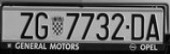

In [650]:
a

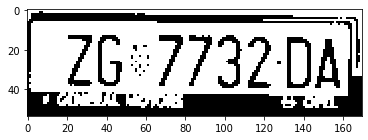

In [651]:
b = cv2.imread('r7.jpg',0)
c = cv2.threshold(b, 70, 255, cv2.THRESH_BINARY)[1]
plt.imshow(c, cmap='gray')

In [646]:
tess.image_to_string(c, config='--psm 8')

'| 26°7732 DA]'

In [647]:
tess.image_to_string(b, config='--psm 8')

'| 2627732 0A]'